# Load the packages

In [1]:
# Run in terminal or command prompt
# python3 -m spacy download en

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# Import Newsgroups Text Data
The core package used in this tutorial is scikit-learn (sklearn).

Regular expressions re, gensim and spacy are used to process texts. pyLDAvis and matplotlib for visualization and numpy and pandas for manipulating and viewing data in tabular format.

In [2]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head()

(2361, 3)


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
10007,From: jet@netcom.Netcom.COM (J. Eric Townsend)...,8,rec.motorcycles
10008,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,10,rec.sport.hockey
10017,From: nstramer@supergas.dazixco.ingr.com (Naft...,17,talk.politics.mideast
10019,From: mussack@austin.ibm.com (Christopher Muss...,15,soc.religion.christian


# Remove emails and newline characters

In [3]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<ipython-input-3-10af9153bd18>:5: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-3-10af9153bd18>:8: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


['From: (Irwin Arnstein) Subject: Re: Recommendation on Duc Summary: Whats it '
 'worth? Distribution: usa Expires: Sat, 1 May 1993 05:00:00 GMT Organization: '
 'CompuTrac Inc., Richardson TX Keywords: Ducati, GTS, How much? Lines: 13 I '
 'have a line on a Ducati 900GTS 1978 model with 17k on the clock. Runs very '
 'well, paint is the bronze/brown/orange faded out, leaks a bit of oil and '
 'pops out of 1st with hard accel. The shop will fix trans and oil leak. They '
 'sold the bike to the 1 and only owner. They want $3495, and I am thinking '
 'more like $3K. Any opinions out there? Please email me. Thanks. It would be '
 'a nice stable mate to the Beemer. Then Ill get a jap bike and call myself '
 'Axis Motors! -- '
 '----------------------------------------------------------------------- '
 '"Tuba" (Irwin) "I honk therefore I am" CompuTrac-Richardson,Tx DoD #0826 '
 '(R75/6) '
 '----------------------------------------------------------------------- ']


# Tokenize and Clean-up using gensim’s simple_preprocess()¶
The sentences look better now, but you want to tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

# Lemmatization
Lemmatization is a process where we convert words to its root word.
For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.

The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.

You can expect better topics to be generated in the end

In [6]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['irwin arnstein subject recommendation duc summary s worth distribution usa expire sat may gmt organization computrac inc richardson tx keyword ducati gt how much line have line ducati gt model clock run very well paint be bronze brown orange fade leak bit oil pop st hard accel shop will fix tran oil leak sell bike only owner want be think more opinion out there email thank would be nice stable mate beemer then ill get jap bike call axis motor tuba irwin honk therefore be computrac richardson tx dod', 'eric townsend subject insurance lotsa point reply message mon apr gmt organization netcom online communication service line cjackson curtis jackson write cjackson be very glad know none judgemental little shit have cjackson ride drive when too tired sleepy hungover angry distracted cjackson last year why have then may be just as guilty not so judgmental little shit do not drive ride when be impair stop do sort thing when good friend mine get kill drunk driver fail stop red drive side vo

# Create the Document-Word matrix
The LDA topic model algorithm requires a document word matrix as the main input.

You can create one using CountVectorizer. In the below code, I have configured the CountVectorizer to consider words that has occurred at least 10 times (min_df), remove built-in english stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.

So, to create the doc-word matrix, you need to first initialise the CountVectorizer class with the required configuration and then apply fit_transform to actually create the matrix.

Since most cells contain zeros, the result will be in the form of a sparse matrix to save memory.

If you want to materialize it in a **2D array format**, call the **todense()** method of the sparse matrix like its done in the next step.

In [7]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

# Check the Sparsicity

Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, we are interested in knowing what percentage of cells contain non-zero values.

In [8]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.0329051754218486 %


# Build LDA model with sklearn
Everything is ready to build a Latent Dirichlet Allocation (LDA) model. Let’s initialise one and call fit_transform() to build the LDA model.

For this example, I have set the n_topics as 20 based on prior knowledge about the dataset. Later we will find the optimal number using grid search.

In [10]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


# Diagnose model performance with perplexity and log-likelihood
A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [11]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2018938.6393976936
Perplexity:  1152.1289349279937
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


On a different note, perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words. This can be captured using topic coherence measure, an example of this is described in the gensim tutorial I mentioned earlier

# How to GridSearch the best LDA model?
The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well.

Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter. These could be worth experimenting if you have enough computing resources.

Be warned, the grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.

In [12]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

# How to see the best topic model and its parameters?

In [13]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -717480.0025064996
Model Perplexity:  1177.5270845238163


# Compare LDA Model Performance Scores
Plotting the log-likelihood scores against num_topics, clearly shows number of topics = 10 has better scores. And learning_decay of 0.7 outperforms both 0.5 and 0.9.

This makes me think, even though we know that the dataset has 20 distinct topics to start with, some topics could share common keywords. For example, ‘alt.atheism’ and ‘soc.religion.christian’ can have a lot of common words. Same with ‘rec.motorcycles’ and ‘rec.autos’, ‘comp.sys.ibm.pc.hardware’ and ‘comp.sys.mac.hardware’, you get the idea.

To tune this even further, you can do a finer grid search for number of topics between 10 and 15. But I am going to skip that for now.

So the bottom line is, a lower optimal number of distinct topics (even 10 topics) may be reasonable for this dataset. I don’t know that yet. But LDA says so. Let’s see.

In [20]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

TypeError: string indices must be integers

# How to see the dominant topic in each document?
To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In the table below, I’ve greened out all major topics in a document and assigned the most dominant topic in its own column.

In [23]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0,0,0,0,0,0.88,0.1,0,0,6
Doc1,0.05,0,0,0,0,0.25,0.5,0,0,0.19,6
Doc2,0,0,0,0,0,0,0.18,0,0.48,0.32,8
Doc3,0,0,0.12,0,0,0.71,0,0.16,0,0,5
Doc4,0,0,0.11,0,0.83,0,0.06,0,0,0,4
Doc5,0,0,0.09,0,0.67,0,0.23,0,0,0,4
Doc6,0,0,0,0,0,0,0.98,0,0,0,6
Doc7,0,0,0,0,0.94,0,0,0.05,0,0,4
Doc8,0.99,0,0,0,0,0,0,0,0,0,0
Doc9,0.79,0.19,0,0,0,0,0,0,0,0,0


# Review topics distribution across documents

In [24]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,6,612
1,4,509
2,5,327
3,0,189
4,8,185
5,9,172
6,2,133
7,3,88
8,1,83
9,7,63


# How to visualize the LDA model with pyLDAvis?
The pyLDAvis offers the best visualization to view the topics-keywords distribution.

A good topic model will have non-overlapping, fairly big sized blobs for each topic. This seems to be the case here. So, we are good.

In [25]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      207.733566 -133.084686       1        1  22.660428
2     -151.254868  -38.474819       2        1  15.513924
5      101.424744  136.231964       3        1  14.093249
6      -23.246778  -39.985878       4        1  13.216979
0       75.556778 -118.740471       5        1   7.875402
8       78.330200 -247.438278       6        1   7.455805
3      225.170273   15.778557       7        1   7.325533
9      -45.076218   94.362122       8        1   4.695885
1       94.438789    6.241585       9        1   3.991293
7      -63.621487 -177.121399      10        1   3.171502, topic_info=     Category         Freq          Term        Total  loglift  logprob
190   Default  1326.000000      armenian  1326.000000  30.0000  30.0000
1495  Default  1508.000000           god  1508.000000  29.0000  29.0000
1848  Default   927.000000        israel   927.000000  28.0000  28.0000
1849  Default   798.000000       israeli   798.000000  27.0000  27.0000
1439  Default   969.000000          game   969.000000  26.0000  26.0000
3474  Default   971.000000          team   971.000000  25.0000  25.0000
355   Default   703.000000          bike   703.000000  24.0000  24.0000
2613  Default   837.000000          play   837.000000  23.0000  23.0000
2462  Default  2309.000000  organization  2309.000000  22.0000  22.0000
3629  Default   729.000000       turkish   729.000000  21.0000  21.0000
2054  Default  2597.000000          line  2597.000000  20.0000  20.0000
3384  Default  2560.000000       subject  2560.000000  19.0000  19.0000
1884  Default   616.000000           jew   616.000000  18.0000  18.0000
592   Default   888.000000     christian   888.000000  17.0000  17.0000
174   Default   526.000000          arab   526.000000  16.0000  16.0000
1524  Default   395.000000         greek   395.000000  15.0000  15.0000
1638  Default   635.000000        hockey   635.000000  14.0000  14.0000
2614  Default   521.000000        player   521.000000  13.0000  13.0000
3664  Default  1270.000000    university  1270.000000  12.0000  12.0000
1051  Default   452.000000           dod   452.000000  11.0000  11.0000
2551  Default   325.000000        period   325.000000  10.0000  10.0000
2651  Default  1272.000000          post  1272.000000   9.0000   9.0000
203   Default  1747.000000       article  1747.000000   8.0000   8.0000
3834  Default  2320.000000         write  2320.000000   7.0000   7.0000
3796  Default   474.000000           win   474.000000   6.0000   6.0000
2363  Default   400.000000           nhl   400.000000   5.0000   5.0000
1664  Default   790.000000          host   790.000000   4.0000   4.0000
2373  Default   762.000000          nntp   762.000000   3.0000   3.0000
1491  Default   368.000000          goal   368.000000   2.0000   2.0000
3091  Default   410.000000        season   410.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
204   Topic10    18.080998    artificial    26.468861   3.0699  -6.2193
70    Topic10    15.949925       african    23.507251   3.0631  -6.3447
3291  Topic10    11.816597         spike    17.505487   3.0580  -6.6447
3816  Topic10    22.215615         women    36.187785   2.9630  -6.0134
3047  Topic10    52.252607           san   108.396123   2.7213  -5.1581
1332  Topic10    53.091408          file   116.715595   2.6632  -5.1422
2795  Topic10    26.315795        racism    48.067512   2.8485  -5.8440
2213  Topic10    71.663727       michael   183.366632   2.5115  -4.8422
37    Topic10    30.501025      activity    59.852379   2.7768  -5.6964
3123  Topic10    21.085578          serb    38.200860   2.8567  -6.0656
2625  Topic10    45.545371        police   118.076142   2.4983  -5.2955
1768  Topic10    66.981010   information   211.338874   2.3019  -4.9098
2581  Topic10    41.405491         phone   107.033296   2.5012  -5.3908
485   Topic10    43.1

# How to see the Topic’s keywords?
The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.

In [26]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaron,abandon,abc,aberystwyth,ability,able,abraham,abroad,absence,absolute,...,youth,ysebaert,yugoslavia,yzerman,zealand,zhamnov,zionism,zionist,zone,zubov
Topic0,0.100000,0.100025,0.100013,0.100000,7.529023,27.198280,0.100001,0.100000,0.100001,0.100009,...,0.100397,0.100050,0.100001,0.100019,0.100023,0.100014,0.100000,0.100000,40.834494,0.100002
Topic1,0.100002,0.100000,0.100006,0.100000,4.473126,1.485378,0.100000,0.100001,0.100000,0.100004,...,1.296472,11.226348,0.100000,30.080382,0.100002,10.136412,0.100000,0.100000,0.100009,16.099979
Topic2,0.100002,3.775137,0.100000,0.100001,5.485735,36.030731,0.100001,9.727427,0.926699,0.100052,...,15.516930,0.100000,0.100018,0.100000,0.100005,0.100000,0.100001,0.100014,3.515917,0.100000
Topic3,0.100010,4.578463,0.100001,0.100000,0.100005,5.286090,0.112659,3.472089,1.344020,1.838158,...,0.100010,0.100000,6.127861,0.100000,0.430256,0.100000,0.100015,0.100656,0.612387,0.100000
Topic4,16.099972,4.226728,0.100000,0.100000,41.778123,66.567931,15.087337,0.100028,10.010113,167.662589,...,0.100015,0.100000,4.045046,0.100000,3.244554,0.100000,0.100001,0.100001,0.100000,0.100000


# Get the top 15 keywords each topic
From the above output, I want to see the top 15 keywords that are representative of the topic.

The show_topics() defined below creates that.

In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

# How to predict the topics for a new piece of text?
Assuming that you have already built the topic model, you need to take the text through the same routine of transformations and before predicting the topic.
For our case, the order of transformations is:
    
**sent_to_words() –> lemmatization() –> vectorizer.transform() –> best_lda_model.transform()**

You need to apply these transformations in the same order. So to simplify it, let’s combine these steps into a predict_topic() function.

In [28]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

[16.099971879450482, 4.226727810147708, 0.10000006430535807, 0.10000037140911584, 41.77812268424063, 66.56793082389518, 15.087336852847638, 0.10002753822015896, 10.010113112504184, 167.66258942557965, 27.76603639111285, 4.2024997333571426, 14.921345850624382, 8.096295695220181, 0.10000000000913094, 163.6265482904441, 7.077655710665924, 6.453377518995771, 0.1063373654525694, 0.10000403115409545, 1.3995490405527085, 9.51390973475312, 64.78978478378424, 3.57025267521683, 44.56590666525459, 8.503649409265053, 3.0999747210665163, 11.574272498210606, 0.10000535206145057, 15.025143314824241, 28.642869773156214, 2.119322942514982, 96.56913255333008, 58.3162075761178, 10.753076084380067, 0.10000221114480365, 0.10000130510663954, 2.894894292627999, 16.921068312880433, 81.1199994296902, 26.219552768668237, 34.52851624848309, 6.536448299164467, 3.615501129906938, 21.174249251700207, 0.1000000000020808, 0.10000006697847569, 0.10000402087765663, 0.1000000000272187, 2.42212497029947, 27.4776213286641

# How to cluster documents that share similar topics and plot?
You can use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object. Since out best model has 15 clusters, I’ve set n_clusters=15 in KMeans().

Alternately, you could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.
We now have the cluster number. But we also need the X and Y columns to draw the plot.

For the X and Y, you can use SVD on the lda_output object with n_components as 2. SVD ensures that these two columns captures the maximum possible amount of information from lda_output in the first 2 components.

In [34]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.05  0.02  0.05  0.06  0.56  0.1   0.81  0.08  0.07  0.1 ]
 [-0.   -0.    0.01  0.05  0.82  0.02 -0.57 -0.01 -0.02 -0.03]]
Perc of Variance Explained: 
 [0.13 0.29]


We have the X, Y and the cluster number for each document.

Let’s plot the document along the two SVD decomposed components. The color of points represents the cluster number (in this case) or topic number.

Text(0.5, 1.0, 'Segregation of Topic Clusters')

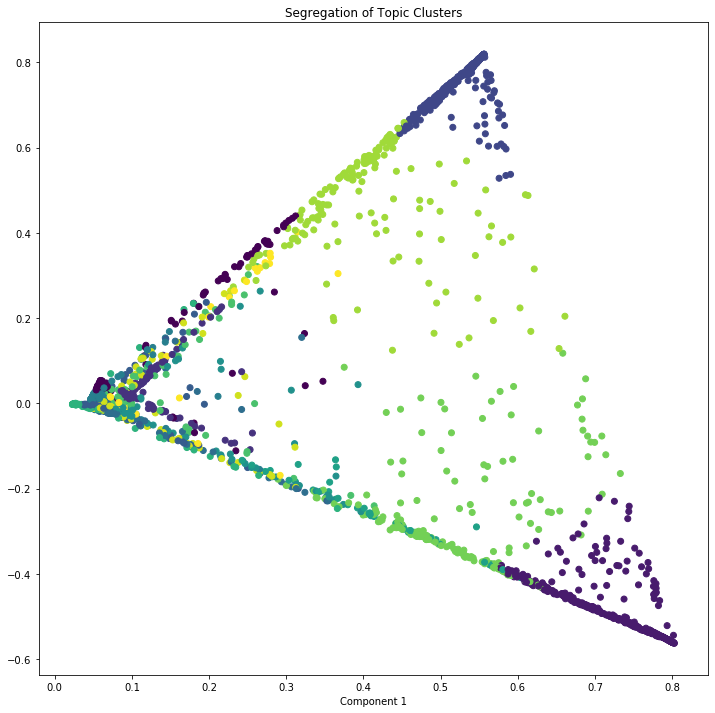

In [35]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

# How to get similar documents for any given piece of text?
Once you know the probaility of topics for a given document (using predict_topic()), compute the euclidean distance with the probability scores of all other documents.

The most similar documents are the ones with the smallest distance.

In [37]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

# Get similar documents
mytext = ["Some text about christianity and bible"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  [16.099971879450482, 4.226727810147708, 0.10000006430535807, 0.10000037140911584, 41.77812268424063, 66.56793082389518, 15.087336852847638, 0.10002753822015896, 10.010113112504184, 167.66258942557965, 27.76603639111285, 4.2024997333571426, 14.921345850624382, 8.096295695220181, 0.10000000000913094, 163.6265482904441, 7.077655710665924, 6.453377518995771, 0.1063373654525694, 0.10000403115409545, 1.3995490405527085, 9.51390973475312, 64.78978478378424, 3.57025267521683, 44.56590666525459, 8.503649409265053, 3.0999747210665163, 11.574272498210606, 0.10000535206145057, 15.025143314824241, 28.642869773156214, 2.119322942514982, 96.56913255333008, 58.3162075761178, 10.753076084380067, 0.10000221114480365, 0.10000130510663954, 2.894894292627999, 16.921068312880433, 81.1199994296902, 26.219552768668237, 34.52851624848309, 6.536448299164467, 3.615501129906938, 21.174249251700207, 0.1000000000020808, 0.10000006697847569, 0.10000402087765663, 0.1000000000272187, 2.42212497029947,


 From: (Dr Nancys Sweetie) Subject: Questioning Authority Organization: Rowan College of New Jersey Lines: 36 Chris Mussack writes: > For all those people who insist I question authority: Why? How about: The Holocaust The Spanish Inquisition Jonestown (just to name a few) ? Authorities sometimes tell people to do evil things. People who "just follow orders" have tortured and killed others in very large numbers, and protest their innocence afterwards. When your authority starts telling you to do t
